In [10]:
!pip install tqdm

     |████████████████████████████████| 72 kB 589 kB/s eta 0:00:011
You should consider upgrading via the '/home/genvekt/.pyenv/versions/3.7.9/envs/dl_tagger_env/bin/python3.7 -m pip install --upgrade pip' command.


In [11]:
import torch
from torch import nn
from tqdm import tqdm
import torch.nn.functional as F

In [189]:
SPECIAL_KEYS = {
    "absent": {
        "word": "ABS",
        "tag": "ABS",
        "char": " "
    },
    "padding": {
        "word": "PAD",
        "tag": "PAD",
        "char": " "
    }
}


WINDOW_LEN = 5
BATCH_SIZE = 20
RANDOM_WORD_SUB=0.01
RANDOM_CHAR_SUB=0.01

In [3]:
def read_dataset(file_path, labeled=True):
    """
    Read the dataset from file
    Args:
        file_path (str): path to the file to read from
        with_tags (bool): flag that indicates the presence of tags in data.
                          Use False to read test data.
    Returns:
        If with_tags is true, the list of tuples, one for each sentence
            One tuple contains list of lowercase words and corresponding list of tags
        Othervise the list of lowercase word lists, one fo each sentence
    """
    
    dataset = []
    with open(file_path, "r") as data_file:
        for line in data_file.readlines():
            # Split each sentence into items
            items = line[:-1].split(" ")
            if labeled:
                # If tags are present, create separate lists of words and tags
                words = []
                tags = []
                for item in items:
                    [word, tag] = item.rsplit("/", 1)
                    words.append(word.lower())
                    tags.append(tag)
                dataset.append((words, tags))
            else:
                # If tags are not present, append word list to the dataset
                dataset.append([word.lower() for word in items])
    return dataset

def add_key_to_dict(key, key_to_idx, idx_to_key):
    if key not in key_to_idx:
        idx = len(key_to_idx)
        key_to_idx[key] = idx
        idx_to_key[idx] = key

def dataset_to_dictionary(dataset, scpecial_keys=None):
    word_to_idx = {}
    idx_to_word = {}
    
    tag_to_idx = {}
    idx_to_tag = {}
    
    char_to_idx = {}
    idx_to_char = {}
    
    for (words, tags) in dataset:
        for word in words:
            add_key_to_dict(word, word_to_idx, idx_to_word)
            for letter in word:
                add_key_to_dict(letter, char_to_idx, idx_to_char)
            
        for tag in tags:
            add_key_to_dict(tag, tag_to_idx, idx_to_tag)
                
    if scpecial_keys is not None:
        add_key_to_dict(scpecial_keys['absent']['word'], word_to_idx, idx_to_word)
        add_key_to_dict(scpecial_keys['padding']['word'], word_to_idx, idx_to_word)
        
        add_key_to_dict(scpecial_keys['absent']['tag'], tag_to_idx, idx_to_tag)
        add_key_to_dict(scpecial_keys['padding']['tag'], tag_to_idx, idx_to_tag)
        for letter in scpecial_keys['absent']['word']:
                add_key_to_dict(letter, char_to_idx, idx_to_char)
        for letter in scpecial_keys['padding']['word']:
                add_key_to_dict(letter, char_to_idx, idx_to_char)

        add_key_to_dict(scpecial_keys['absent']['char'], char_to_idx, idx_to_char)
        add_key_to_dict(scpecial_keys['padding']['char'], char_to_idx, idx_to_char)
        
    return word_to_idx, tag_to_idx, char_to_idx, idx_to_word, idx_to_tag, idx_to_char

def pad_sequence(sequence, pad_key, required_len):
    pad_len = required_len - len(sequence)
    return sequence + [pad_key]*pad_len
    
def prepare_sequence(sequence, 
                     dictionary, 
                     absent_key=None, 
                     pad_key=None, 
                     required_len=50, 
                     random_chance=0):  
    """
    Translate sequence according to dictionary.
    Args:
        sequence (list): list of keys
        dictionary (dict): mapping from key to integer
        absent_key (str): key which will substitute absent keys in sequence.
                            if None, absent keys will be ignored
        random_sub (bool): flag which indicatesthe need to randomly change keys in sequence 
                            with absent key with some chance (10% maybe)
                            if None, random substitution will not be used.
    Returns:
        list of transformed sequence
    """
    translated_seq = []
    for key in sequence:
        # Handle absent keys if absent_key specified
        if key not in dictionary:
            if absent_key is not None:
                translated_seq.append(dictionary[absent_key])
        # Random substitute if random_key specified
        elif absent_key is not None and torch.rand(1)[0]<random_chance:
            translated_seq.append(dictionary[absent_key])
        else:
            translated_seq.append(dictionary[key])
    if pad_key is not None:
        pad_len = required_len - len(translated_seq)
        translated_seq += [dictionary[pad_key]]*pad_len
    return torch.tensor(translated_seq, dtype=torch.long)

In [71]:
train_dataset = read_dataset("../corpus.train", labeled=True)

In [72]:
word_to_idx, tag_to_idx, char_to_idx, idx_to_word, idx_to_tag, idx_to_char = dataset_to_dictionary(train_dataset, 
                                                                                                   scpecial_keys=SPECIAL_KEYS)

In [178]:
import math
class BatchedDataset:
    def __init__(self, 
                 dataset, 
                 word_to_idx, 
                 char_to_idx, 
                 tag_to_idx, 
                 special_keys=None,
                 batch_size = 10, 
                 labeled=True, 
                 sorting=True,
                 random_word_sub=0.0,
                 random_char_sub=0.0):
        
        self.labeled = labeled
        self.word_to_idx = word_to_idx
        self.char_to_idx = char_to_idx
        self.tag_to_idx = tag_to_idx
        self.special_keys = special_keys
        self.random_word_sub = random_word_sub
        self.random_char_sub = random_char_sub
        if sorting:
            # Sort sentens by their length
            dataset = sorted(dataset, key=self.get_sort_func())
        num_batches = math.ceil(len(dataset) / batch_size )
        batches = []
        for i in tqdm(range(num_batches)):
            batch_items = dataset[i*batch_size:(i+1)*batch_size]
            batch = self.create_batch(batch_items)
            batches.append(batch)
        self.batches = batches
        self.word_to_idx = word_to_idx
        self.char_to_idx = char_to_idx
    
    def default_spesial_keys(self):
        return {
            "absent": {
                "word": "ABS",
                "tag": "ABS",
                "char": " "
            },
            "padding": {
                "word": "PAD",
                "tag": "PAD",
                "char": " "
            }
        }
    
    def find_max_word_len(self, items):
        max_word_len = 0
        for item in items:
            if self.labeled:
                sent = item[0]
            else:
                sent = item
            s_max_word_len= max([len(word) for word in sent])
            max_word_len = s_max_word_len if s_max_word_len > max_word_len else max_word_len
        return max_word_len
    
    def get_sort_func(self):
        def sort_func(el):
            if self.labeled:
                return len(el[0])
            else: 
                return len(el)
        return sort_func
    
    def create_batch(self, items):
        # max_s
        if self.labeled:
            max_sentence_len = max([len(item[0]) for item in items])
        else:
            max_sentence_len = max([len(item) for item in items])
        # max_w
        max_word_len = self.find_max_word_len(items)

        batch_sentences = []
        batch_mask = []
        batch_taggs = []
        batch_words = []

        for item in items:
            if self.labeled:
                sent, taggs =  item
                # [?,] -> [max_s,]
                codded_taggs = prepare_sequence(taggs, 
                                            self.tag_to_idx, 
                                            absent_key=self.special_keys['absent']['tag'],
                                            pad_key = self.special_keys['padding']['tag'],
                                            required_len=max_sentence_len,
                                            random_chance=0)
                batch_taggs.append(codded_taggs)
            else:
                sent = item

            # [?,] -> [max_s,]
            padded_sentence = pad_sequence(sent,
                                           pad_key=self.special_keys['padding']['word'],
                                           required_len=max_sentence_len)
            

            codded_sentence = prepare_sequence(padded_sentence, 
                                            self.word_to_idx, 
                                            absent_key=self.special_keys['absent']['word'],
                                            random_chance=self.random_word_sub)
            
            mask = (codded_sentence != self.word_to_idx[self.special_keys['padding']['word']]).type(torch.uint8)  


            batch_sentences.append(codded_sentence)
            batch_mask.append(mask)

            codded_words = []
            for word in padded_sentence:
                # [?,] -> [max_w,]
                codded_word = prepare_sequence(word, 
                                               self.char_to_idx, 
                                               absent_key=self.special_keys['absent']['char'],
                                               pad_key = self.special_keys['padding']['char'],
                                               required_len=max_word_len,
                                               random_chance=self.random_char_sub)

                codded_words.append(codded_word)
            codded_words = torch.stack(codded_words,dim=0)
            batch_words.append(codded_words)

        # [B*max_s, max_w]
        batch_words = torch.cat(batch_words, dim=0)

        # [B,max_s]
        batch_sentences = torch.stack(batch_sentences, dim=0)
        batch_mask = torch.stack(batch_mask, dim=0)

        if self.labeled:
            # [B,max_s] (or [] if labeled id False)
            batch_taggs = torch.stack(batch_taggs, dim=0)

        return batch_sentences, batch_words, batch_taggs, batch_mask
        
    def __len__(self):
        return len(self.batches)
    
    def __getitem__(self, idx):
        return self.batches[idx]
    

In [184]:
bds = BatchedDataset(train_dataset, word_to_idx, char_to_idx, tag_to_idx, special_keys=SPECIAL_KEYS, 
                    batch_size=BATCH_SIZE, labeled=True, sorting=True,
                    random_word_sub=RANDOM_WORD_SUB,
                    random_char_sub=RANDOM_CHAR_SUB)

100%|██████████| 1897/1897 [01:46<00:00, 17.82it/s]


In [180]:
bds[0]

(tensor([[   40,    38,    41,    42,    39, 38473, 38473, 38473, 38473, 38473,
          38473, 38473, 38473, 38473, 38473, 38473, 38473, 38473, 38473, 38473,
          38473, 38473, 38473, 38473, 38473, 38473, 38473, 38473, 38473, 38473,
          38473, 38473, 38473, 38473, 38473, 38473, 38473, 38473, 38473, 38473,
          38473, 38473, 38473, 38473, 38473, 38473, 38473, 38473, 38473],
         [   89,    98,    99,   100,   101,   102,   103,    39, 38473, 38473,
          38473, 38473, 38473, 38473, 38473, 38473, 38473, 38473, 38473, 38473,
          38473, 38473, 38473, 38473, 38473, 38473, 38473, 38473, 38473, 38473,
          38473, 38473, 38473, 38473, 38473, 38473, 38473, 38473, 38473, 38473,
          38473, 38473, 38473, 38473, 38473, 38473, 38473, 38473, 38473],
         [    7,    91,    92,    93,    94,    95,    96,    97,    39, 38473,
          38473, 38473, 38473, 38473, 38473, 38473, 38473, 38473, 38473, 38473,
          38473, 38473, 38473, 38473, 38473, 38473, 

In [181]:
class FinalModel(nn.Module):
    def __init__(self, char_emb_dim, word_emb_dim, hidden_dim, vocab_size, charset_size, tagset_size, window, l):
        super(FinalModel, self).__init__()
        self.char_embeddings = nn.Embedding(charset_size, char_emb_dim)
        self.word_embeddings = nn.Embedding(vocab_size, word_emb_dim)
        self.conv1 = nn.Conv1d(char_emb_dim, l, window, padding=(window-1)//2)
        self.lstm = nn.LSTM(word_emb_dim+l, hidden_dim, bidirectional=True)
        self.hidden2tag = nn.Linear(hidden_dim*2, tagset_size)

    def forward(self, batch_sentence, batch_words):
        # Pass each window through CNN, max_pool the results for each word
        
        B, S = batch_sentence.shape
        
        # [B*S, W, c_emb]
        chars_batch = self.char_embeddings(batch_words)
        
        # [B*S, c_emb, W]
        chars_batch = chars_batch.permute(0,2,1)
        
        # [B*S, l, W]
        conv_out = self.conv1(chars_batch)
        
        # [B*S, l]
        pool_out, _ = torch.max(conv_out, dim=2)
        
        # [B, S, l]
        cnn_word_vecs = pool_out.reshape((B, S, -1))
        
        # [B, S, w_emb]
        word_embeds = self.word_embeddings(batch_sentence)
        
        # [B, S, w_emb+l]
        concated = torch.cat((word_embeds, cnn_word_vecs), dim=2)
        
        # [B, S, hidden]
        lstm_out, _ = self.lstm(concated)
        
        # [B, S, T]
        tag_space = self.hidden2tag(lstm_out)
        tag_scores = F.log_softmax(tag_space, dim=2)
        return tag_scores    

In [187]:
model = FinalModel(char_emb_dim=10, 
                   word_emb_dim=100, 
                   hidden_dim=16, 
                   vocab_size=len(word_to_idx), 
                   charset_size=len(char_to_idx),
                   tagset_size=len(tag_to_idx),
                   window=WINDOW_LEN,
                   l=20)

In [15]:
import torch.optim as optim

In [188]:
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
losses = []

for epoch in range(10):
    for step in range(len(bds)):
        model.zero_grad()

        sentences, words, taggs, mask = bds[step]

        tag_scores = model(sentences, words)
        B, S, T = tag_scores.shape
        # tag_scores = torch.argmax(tag_scores, dim=1) #.reshape(-1)
        mask = mask.reshape(-1)
        tag_scores= tag_scores.reshape((B*S,T))
        tag_scores = tag_scores * mask.unsqueeze(1)
        taggs = taggs.reshape(-1) * mask

        loss = loss_function(tag_scores, taggs)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if step % 500 == 0:
            print(f"\t loss = {losses[-1]}")
    print(f"Epoch {epoch}: loss={losses[-1]}")
    
    with torch.no_grad():
        y_true = []
        y_pred = []
        for step in range(len(batchizer_test)):
            sentences, words, taggs, mask = batchizer_test[step]
            tag_scores = model(sentences, words)
            # tag_scores = torch.argmax(tag_scores, dim=1) #.reshape(-1)
            mask = mask.reshape(-1)
            taggs = taggs.reshape(-1) * mask
            tag_scores= tag_scores.reshape((-1,tag_scores.shape[-1]))
            pred = torch.argmax(tag_scores, dim=1)*mask
            # print(taggs.shape, pred.shape)
            y_true += taggs.tolist()
            y_pred += pred.tolist()
        print("Val accuracy:",accuracy_score(y_true, y_pred))
        
    torch.save(model, 'model.pth')

	 loss = 3.806893825531006
	 loss = 0.5268096327781677
	 loss = 0.2668271064758301
	 loss = 0.20654650032520294
Epoch 0: loss=0.22369877994060516
Val accuracy: 0.9146148682301479
	 loss = 0.4512713849544525


/home/genvekt/.pyenv/versions/3.7.9/envs/dl_tagger_env/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type FinalModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


	 loss = 0.3112446665763855
	 loss = 0.1868566870689392
	 loss = 0.17567184567451477
Epoch 1: loss=0.1816858947277069
Val accuracy: 0.9165204963295004
	 loss = 0.2689725458621979


/home/genvekt/.pyenv/versions/3.7.9/envs/dl_tagger_env/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type FinalModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


	 loss = 0.2768263816833496
	 loss = 0.1725994497537613
	 loss = 0.15808017551898956
Epoch 2: loss=0.16721951961517334
Val accuracy: 0.9164555317352043
	 loss = 0.22781860828399658


/home/genvekt/.pyenv/versions/3.7.9/envs/dl_tagger_env/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type FinalModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


KeyboardInterrupt: 

In [163]:
test_dataset = read_dataset("../corpus.answer", labeled=True)
batchizer_test = BatchedDataset(test_dataset, word_to_idx, char_to_idx, tag_to_idx, 
                                batch_size=BATCH_SIZE, special_keys=SPECIAL_KEYS,labeled=True,sorting=True,
                                random_word_sub=0.0, random_char_sub=0.0)

100%|██████████| 95/95 [00:05<00:00, 18.57it/s]


In [93]:
model.eval()

FinalModel(
  (char_embeddings): Embedding(64, 30)
  (word_embeddings): Embedding(38474, 50)
  (conv1): Conv1d(30, 20, kernel_size=(5,), stride=(1,), padding=(2,))
  (lstm): LSTM(70, 40, bidirectional=True)
  (hidden2tag): Linear(in_features=80, out_features=48, bias=True)
)

In [94]:
y_true = []
y_pred = []
for step in range(len(batchizer_test)):
    sentences, words, taggs = batchizer_test[step]
    tag_scores = model(sentences, words)
    # tag_scores = torch.argmax(tag_scores, dim=1) #.reshape(-1)
    taggs = taggs.reshape(-1)
    tag_scores= tag_scores.reshape((-1,tag_scores.shape[-1]))
    pred = torch.argmax(tag_scores, dim=1)
    # print(taggs.shape, pred.shape)
    y_true += taggs.tolist()
    y_pred += pred.tolist()


In [95]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_true, y_pred))

0.8347018765464538


In [82]:
import matplotlib.pyplot as plt

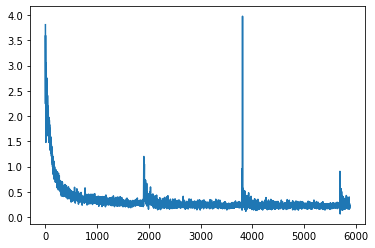

In [190]:
plt.plot(list(range(len(losses))), losses)
plt.show()

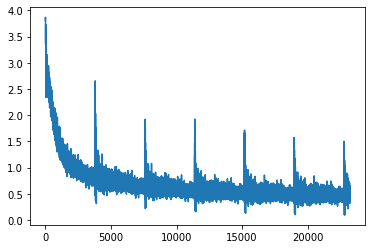

In [104]:
plt.plot(list(range(len(losses))), losses)
plt.show()

In [58]:
!pip install sklearn

  Using cached sklearn-0.0.tar.gz (1.1 kB)
     |████████████████████████████████| 22.3 MB 4.1 MB/s eta 0:00:01
  Using cached threadpoolctl-2.1.0-py3-none-any.whl (12 kB)
     |████████████████████████████████| 303 kB 3.6 MB/s eta 0:00:01
     |████████████████████████████████| 27.4 MB 6.2 MB/s eta 0:00:01
Using legacy setup.py install for sklearn, since package 'wheel' is not installed.
    Running setup.py install for sklearn ... done
You should consider upgrading via the '/home/genvekt/.pyenv/versions/3.7.9/envs/dl_tagger_env/bin/python3.7 -m pip install --upgrade pip' command.


In [81]:
!pip install matplotlib

     |████████████████████████████████| 11.5 MB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 3.6 MB/s eta 0:00:01
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
You should consider upgrading via the '/home/genvekt/.pyenv/versions/3.7.9/envs/dl_tagger_env/bin/python3.7 -m pip install --upgrade pip' command.
